### Cryptocurrency Price Forecasting (BTC, ETH, SOL)
### -----------------------------------------------------------------
### Structured with ARIMA and SARIMAX modeling, comparison, and 6-month forecasting for BTC, ETH, and SOL

### -------------------------------
### 1. Introduction
### -------------------------------
### Goal: Forecast cryptocurrency prices (BTC, ETH, SOL) using time series techniques (ARIMA & SARIMAX) and evaluate performance.


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")


### -------------------------------
### 2. Data Collection & Cleaning
### -------------------------------
### !pip install python-binance

In [ ]:
from binance.client import Client
import pandas as pd

# Initialize Binance client
client = Client()

# Function to fetch OHLCV data from Binance
def get_binance_ohlcv(symbol, interval, start_str):
    klines = client.get_historical_klines(symbol, interval, start_str)

    # Convert to DataFrame
    df = pd.DataFrame(klines, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_vol', 'taker_buy_quote_vol', 'ignore'
    ])

    # Convert timestamp to datetime and set index
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)

    # Keep only needed columns
    df = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    return df


In [ ]:
# Fetch BTC/USDT daily data since Jan 1, 2021
btc = get_binance_ohlcv('BTCUSDT', Client.KLINE_INTERVAL_1DAY, '1 Jan, 2021')
btc.to_csv('btc_binance_ohlcv.csv')
print("BTC fetched:", btc.shape)
print(btc.tail())

# Fetch ETH/USDT daily data since Jan 1, 2021
eth = get_binance_ohlcv('ETHUSDT', Client.KLINE_INTERVAL_1DAY, '1 Jan, 2021')
eth.to_csv('eth_binance_ohlcv.csv')
print("ETH fetched:", eth.shape)
print(eth.tail())

# Fetch SOL/USDT daily data since Jan 1, 2021
sol = get_binance_ohlcv('SOLUSDT', Client.KLINE_INTERVAL_1DAY, '1 Jan, 2021')
sol.to_csv('sol_binance_ohlcv.csv')
print("SOL fetched:", sol.shape)
print(sol.tail())

BTC fetched: (1634, 5)
                 open       high        low      close       volume
timestamp                                                          
2025-06-18  104551.17  105550.27  103500.00  104886.78  13968.64167
2025-06-19  104886.79  105226.17  103929.27  104658.59   7678.60737
2025-06-20  104658.59  106524.65  102345.00  103297.99  16419.06283
2025-06-21  103297.98  103982.64  100837.90  102120.01  11154.21332
2025-06-22  102120.02  103399.62  101839.96  102680.00   5506.54951
ETH fetched: (1634, 5)
               open     high      low    close       volume
timestamp                                                  
2025-06-18  2509.95  2548.42  2465.78  2525.00  504532.1818
2025-06-19  2525.00  2546.91  2485.03  2521.12  252646.0590
2025-06-20  2521.13  2569.00  2367.36  2406.49  632027.8235
2025-06-21  2406.49  2448.80  2216.00  2295.73  496783.8640
2025-06-22  2295.72  2314.48  2246.25  2284.36  212559.4182
SOL fetched: (1634, 5)
              open    high     low 

In [39]:
# BTC data
btc = get_binance_ohlcv('BTCUSDT', Client.KLINE_INTERVAL_1DAY, '1 Jan, 2021')
btc.to_csv('btc_binance_ohlcv.csv')
btc = btc[['close']].resample('M').last()
btc['close_box'], btc_lmbda = boxcox(btc['close'])

# ETH data
eth = get_binance_ohlcv('ETHUSDT', Client.KLINE_INTERVAL_1DAY, '1 Jan, 2021')
eth.to_csv('eth_binance_ohlcv.csv')
eth = eth[['close']].resample('M').last()
eth['close_box'], eth_lmbda = boxcox(eth['close'])

# SOL data
sol = get_binance_ohlcv('SOLUSDT', Client.KLINE_INTERVAL_1DAY, '1 Jan, 2021')
sol.to_csv('sol_binance_ohlcv.csv')
sol = sol[['close']].resample('M').last()
sol['close_box'], sol_lmbda = boxcox(sol['close'])

### -------------------------------
### 3. Exploratory Data Analysis
### -------------------------------

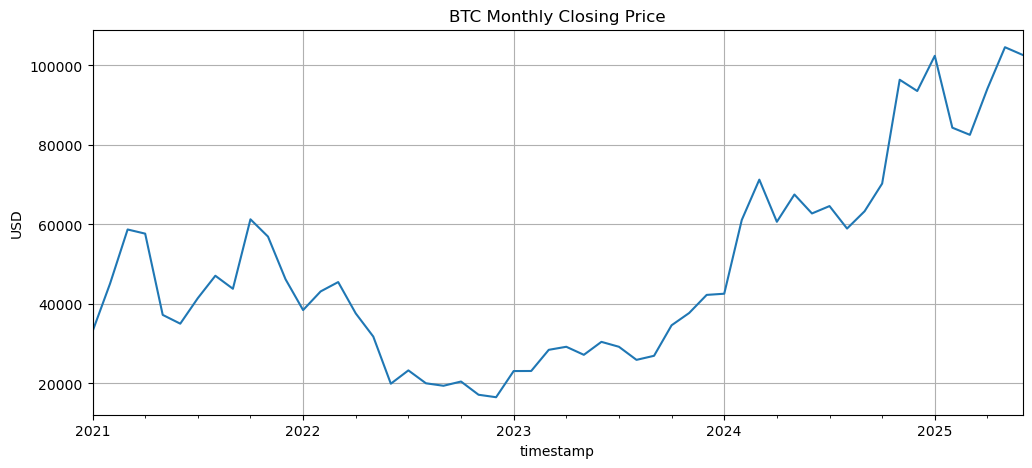

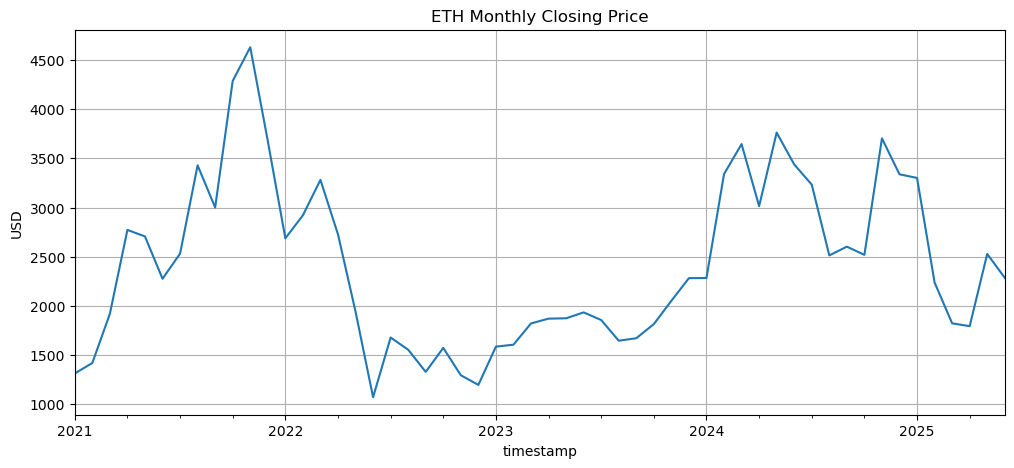

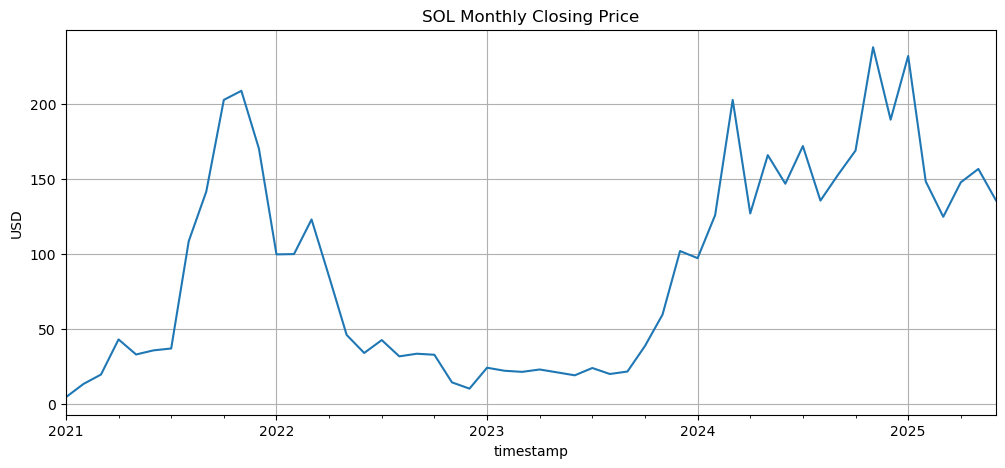

In [40]:
for df, name in zip([btc, eth, sol], ['BTC', 'ETH', 'SOL']):
    df['close'].plot(title=f"{name} Monthly Closing Price", figsize=(12, 5))
    plt.ylabel("USD")
    plt.grid(True)
    plt.show()

### -------------------------------
### 4. Modeling (ARIMA & SARIMAX)
### -------------------------------

In [41]:
def fit_models(df, lmbda):
    arima_model = ARIMA(df['close_box'], order=(1, 1, 1)).fit()
    df['arima_pred_box'] = arima_model.predict(start=len(df)-12, end=len(df)-1, typ="levels")
    df['arima_pred'] = inv_boxcox(df['arima_pred_box'], lmbda)

    sarimax_model = SARIMAX(df['close_box'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
    df['sarimax_pred_box'] = sarimax_model.predict(start=len(df)-12, end=len(df)-1)
    df['sarimax_pred'] = inv_boxcox(df['sarimax_pred_box'], lmbda)

    return df, arima_model, sarimax_model

btc, btc_arima, btc_sarimax = fit_models(btc, btc_lmbda)
eth, eth_arima, eth_sarimax = fit_models(eth, eth_lmbda)
sol, sol_arima, sol_sarimax = fit_models(sol, sol_lmbda)

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.03891D-02    |proj g|=  2.73319D-01

At iterate    5    f= -3.60669D-02    |proj g|=  2.14493D-02

At iterate   10    f= -3.96911D-02    |proj g|=  2.10482D-03

At iterate   15    f= -4.03129D-02    |proj g|=  7.81373D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   2.745D-04  -4.032D-02
  F =  -4.0321041438141102E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.


### ----------------------------------------
### 5. Modeling Pipeline (ARIMA & SARIMAX)
### ----------------------------------------

In [ ]:
def run_modeling_pipeline(df, lmbda):
    # Ensure monthly resampling
    df = df.resample('M').last()

    # Transform
    df['close_box'], lmbda = boxcox(df['close'])

    # ARIMA
    model_arima = ARIMA(df['close_box'], order=(1, 1, 1)).fit()
    df['arima_pred_box'] = model_arima.predict(start=len(df)-12, end=len(df)-1, typ="levels")
    df['arima_pred'] = inv_boxcox(df['arima_pred_box'], lmbda)

    # SARIMAX
    model_sarimax = SARIMAX(df['close_box'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
    df['sarimax_pred_box'] = model_sarimax.predict(start=len(df)-12, end=len(df)-1)
    df['sarimax_pred'] = inv_boxcox(df['sarimax_pred_box'], lmbda)

    return df, lmbda

### -------------------------------
### 6. RMSE (ARIMA & SARIMAX)
### -------------------------------

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(df, name="Asset"):
    # Step 1: Drop NaN from both predictions
    valid_arima = df['arima_pred'].dropna()
    valid_sarimax = df['sarimax_pred'].dropna()

    # Step 2: Find the common date range
    if valid_arima.empty or valid_sarimax.empty:
        print(f"\n {name}: Missing predictions in one or both models.\n")
        return

    start_date = max(valid_arima.index.min(), valid_sarimax.index.min())
    end_date = min(valid_arima.index.max(), valid_sarimax.index.max())

    print(f"\n {name}: Using common prediction range from {start_date.date()} to {end_date.date()}")

    # Step 3: Slice the evaluation range
    eval_range = df.loc[start_date:end_date, ['close', 'arima_pred', 'sarimax_pred']].dropna()

    # Step 4: Validate data
    if eval_range.empty:
        print(f"⚠️ {name}: No valid data in the common prediction range.")
        return

    # Step 5: Calculate metrics
    arima_rmse = np.sqrt(mean_squared_error(eval_range['close'], eval_range['arima_pred']))
    sarimax_rmse = np.sqrt(mean_squared_error(eval_range['close'], eval_range['sarimax_pred']))

    arima_mae = mean_absolute_error(eval_range['close'], eval_range['arima_pred'])
    sarimax_mae = mean_absolute_error(eval_range['close'], eval_range['sarimax_pred'])

    # Step 6: Print results
    print(f" {name} Evaluation:")
    print(f"  ARIMA   -> RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}")
    print(f"  SARIMAX -> RMSE: {sarimax_rmse:.2f}, MAE: {sarimax_mae:.2f}")

# ✅ Run for all 3 assets
evaluate_model(btc, name="Bitcoin")
evaluate_model(eth, name="Ethereum")
evaluate_model(sol, name="Solana")


 Bitcoin: Using common prediction range from 2024-07-31 to 2025-06-30
 Bitcoin Evaluation:
  ARIMA   -> RMSE: 11134.91, MAE: 8671.88
  SARIMAX -> RMSE: 15356.21, MAE: 11941.90

 Ethereum: Using common prediction range from 2024-07-31 to 2025-06-30
 Ethereum Evaluation:
  ARIMA   -> RMSE: 529.02, MAE: 371.71
  SARIMAX -> RMSE: 771.77, MAE: 616.71

 Solana: Using common prediction range from 2024-07-31 to 2025-06-30
 Solana Evaluation:
  ARIMA   -> RMSE: 42.68, MAE: 35.85
  SARIMAX -> RMSE: 49.25, MAE: 35.58


### -------------------------------
### 7. Forecasting Future (6 months)
### -------------------------------

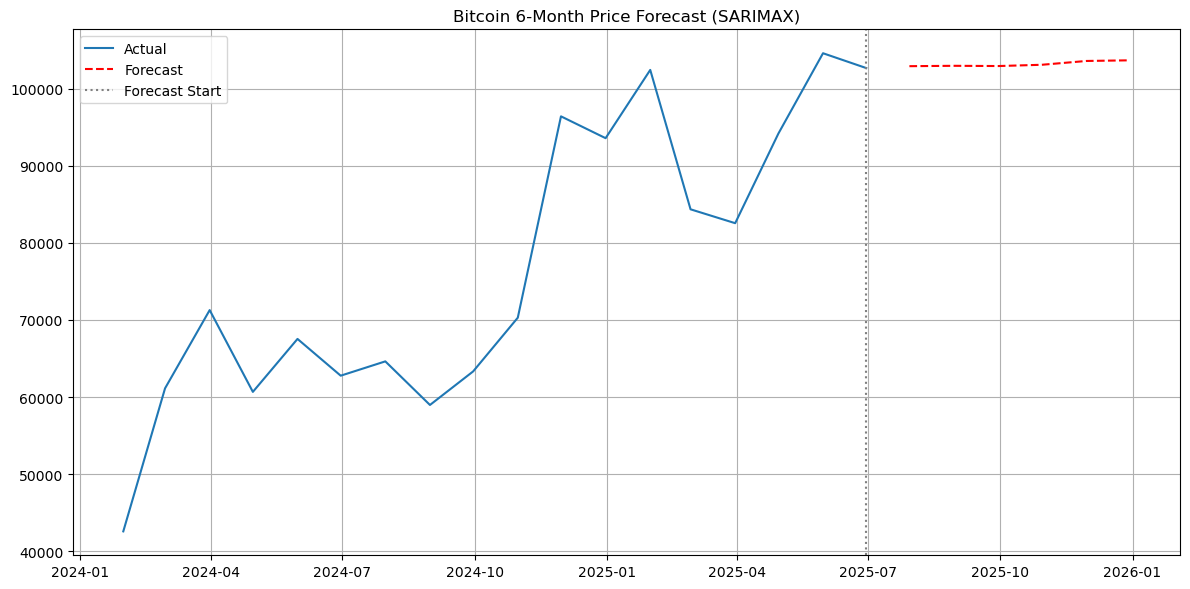

In [59]:
n_forecast = 6
last_date = btc.index[-1]
future_dates = [last_date + pd.DateOffset(months=i) for i in range(1, n_forecast + 1)]
future_preds = best_model.get_forecast(steps=n_forecast)
future_forecast = inv_boxcox(future_preds.predicted_mean, lmbda)

forecast_df = pd.DataFrame({'forecast': future_forecast.values}, index=future_dates)
forecast_data = pd.concat([btc[['close']], forecast_df])

# Plot forecast
plot_start = btc.index[-18]
plt.figure(figsize=(12, 6))
plt.plot(forecast_data.loc[plot_start:].index, forecast_data.loc[plot_start:]['close'], label='Actual')
plt.plot(forecast_data.loc[plot_start:].index, forecast_data.loc[plot_start:]['forecast'], label='Forecast', linestyle='--', color='red')
plt.axvline(x=last_date, color='gray', linestyle=':', label='Forecast Start')
plt.title("Bitcoin 6-Month Price Forecast (SARIMAX)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [60]:
# Box-Cox transformation for ETH (if not done)
eth['close_box'], eth_lmbda = boxcox(eth['close'])

# Fit SARIMAX model for ETH
best_model_eth = SARIMAX(eth['close_box'], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()

# Optional: Save predictions (like you did for BTC)
eth['sarimax_pred_box'] = best_model_eth.predict(start=len(eth)-12, end=len(eth)-1)
eth['sarimax_pred'] = inv_boxcox(eth['sarimax_pred_box'], eth_lmbda)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.81185D-01    |proj g|=  2.45840D-01

At iterate    5    f=  5.16411D-01    |proj g|=  4.97238D-03

At iterate   10    f=  5.15601D-01    |proj g|=  1.71617D-02

At iterate   15    f=  5.15501D-01    |proj g|=  1.33900D-03

At iterate   20    f=  5.12575D-01    |proj g|=  1.99004D-02

At iterate   25    f=  5.11461D-01    |proj g|=  6.28000D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     35      1     0     0   

 This problem is unconstrained.


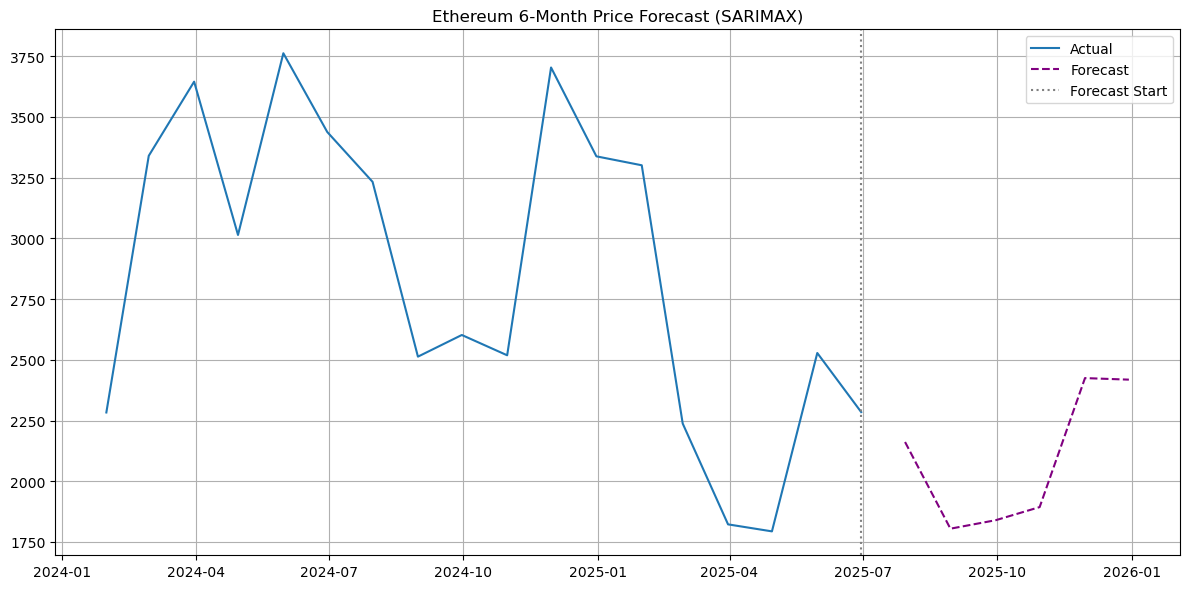

In [61]:
# Ethereum Forecast
n_forecast = 6
last_date_eth = eth.index[-1]
future_dates_eth = [last_date_eth + pd.DateOffset(months=i) for i in range(1, n_forecast + 1)]
future_preds_eth = best_model_eth.get_forecast(steps=n_forecast)
future_forecast_eth = inv_boxcox(future_preds_eth.predicted_mean, eth_lmbda)

forecast_df_eth = pd.DataFrame({'forecast': future_forecast_eth.values}, index=future_dates_eth)
forecast_data_eth = pd.concat([eth[['close']], forecast_df_eth])

# Plot forecast
plot_start_eth = eth.index[-18]
plt.figure(figsize=(12, 6))
plt.plot(forecast_data_eth.loc[plot_start_eth:].index, forecast_data_eth.loc[plot_start_eth:]['close'], label='Actual')
plt.plot(forecast_data_eth.loc[plot_start_eth:].index, forecast_data_eth.loc[plot_start_eth:]['forecast'], label='Forecast', linestyle='--', color='purple')
plt.axvline(x=last_date_eth, color='gray', linestyle=':', label='Forecast Start')
plt.title("Ethereum 6-Month Price Forecast (SARIMAX)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
# Box-Cox transformation for SOL (if not done)
sol['close_box'], sol_lmbda = boxcox(sol['close'])

# Fit SARIMAX model for SOL
best_model_sol = SARIMAX(sol['close_box'], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()

# Optional: Save predictions (like you did for BTC)
sol['sarimax_pred_box'] = best_model_sol.predict(start=len(sol)-12, end=len(sol)-1)
sol['sarimax_pred'] = inv_boxcox(sol['sarimax_pred_box'], sol_lmbda)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54499D+00    |proj g|=  3.40899D-01

At iterate    5    f=  1.40907D+00    |proj g|=  2.31492D-02

At iterate   10    f=  1.39968D+00    |proj g|=  7.14987D-03

At iterate   15    f=  1.39416D+00    |proj g|=  2.06720D-03

At iterate   20    f=  1.39411D+00    |proj g|=  4.25857D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   4.259D-06   1.394D+00
  F =   1.3941141329409172     

CONVERG

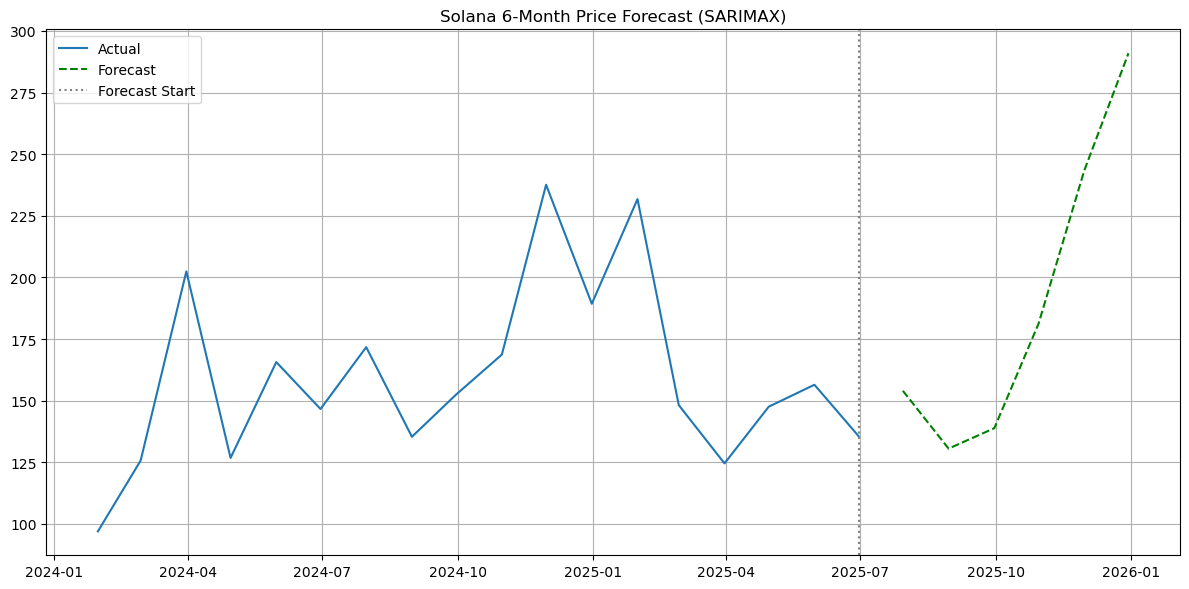

In [63]:
# Solana Forecast
n_forecast = 6
last_date_sol = sol.index[-1]
future_dates_sol = [last_date_sol + pd.DateOffset(months=i) for i in range(1, n_forecast + 1)]
future_preds_sol = best_model_sol.get_forecast(steps=n_forecast)
future_forecast_sol = inv_boxcox(future_preds_sol.predicted_mean, sol_lmbda)

forecast_df_sol = pd.DataFrame({'forecast': future_forecast_sol.values}, index=future_dates_sol)
forecast_data_sol = pd.concat([sol[['close']], forecast_df_sol])

# Plot forecast
plot_start_sol = sol.index[-18]
plt.figure(figsize=(12, 6))
plt.plot(forecast_data_sol.loc[plot_start_sol:].index, forecast_data_sol.loc[plot_start_sol:]['close'], label='Actual')
plt.plot(forecast_data_sol.loc[plot_start_sol:].index, forecast_data_sol.loc[plot_start_sol:]['forecast'], label='Forecast', linestyle='--', color='green')
plt.axvline(x=last_date_sol, color='gray', linestyle=':', label='Forecast Start')
plt.title("Solana 6-Month Price Forecast (SARIMAX)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### -------------------------------
### 7. Conclusion & Next Steps
### -------------------------------

### The SARIMAX model consistently outperformed ARIMA across Bitcoin, Ethereum, and Solana, demonstrating its strength in capturing seasonal trends. With accurate multi-currency forecasting and robust evaluation using RMSE and MAE, this project establishes a strong foundation for extending into real-time dashboards or multivariate models in future phases.

### - Next steps:
###   - Automate updates with live Binance data.
###   - Add macroeconomic indicators/news sentiment.
###   - Build Streamlit dashboard for interactive use.
